In [ ]:
!sudo apt-get update
!sudo apt-get install -y gcc


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,835 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,491 kB]
Get:14 http://security.ubuntu.com/ubuntu jamm

In [ ]:
pip install Pillow

In [ ]:
from PIL import Image
import io

# Assuming the uploaded file is the first (and only) one in 'uploaded'
# and its content is in bytes

image_data = list(uploaded.values())[0]
img = Image.open(io.BytesIO(image_data))

# Convert to grayscale if it's not already, as Sobel typically works on grayscale
if img.mode != 'L':
    img = img.convert('L')

# Save as PGM
output_pgm_path = 'input.pgm'
img.save(output_pgm_path, format='PPM') # PPM can handle grayscale, and PGM is a subset

print(f'Converted image saved as {output_pgm_path}')

NameError: name 'uploaded' is not defined

In [ ]:
!sudo apt-get update -y
!sudo apt-get install -y gcc

In [ ]:
%%writefile sobel_omp.c
/*
  sobel_omp.c
  Compile:
    gcc -O2 -fopenmp sobel_omp.c -o sobel_omp -lm

  Usage:
    ./sobel_omp input.pgm output_parallel.pgm [num_threads]

  Notes:
  - Input must be a grayscale PGM file (P5 or P2). If you have RGB images,
    convert them to grayscale/PGM before running (or I can give a helper).
  - The program runs both sequential and parallel Sobel and prints timings.
*/

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>

#define CLAMP(x, lo, hi) ((x) < (lo) ? (lo) : ((x) > (hi) ? (hi) : (x)))

// --- PGM reader (supports P5 binary and P2 ASCII) ---
unsigned char *read_pgm(const char *filename, int *width, int *height) {
    FILE *f = fopen(filename, "rb");
    if (!f) { perror("fopen"); return NULL; }

    char magic[3] = {0};
    if (!fgets(magic, sizeof(magic), f)) { fclose(f); return NULL; }

    if (strncmp(magic, "P5", 2) != 0 && strncmp(magic, "P2", 2) != 0) {
        // try skipping potential leading spaces
        rewind(f);
        if (!fgets(magic, sizeof(magic), f)) { fclose(f); return NULL; }
        if (strncmp(magic, "P5", 2) != 0 && strncmp(magic, "P2", 2) != 0) {
            fprintf(stderr, "Unsupported PGM format: %s\n", magic);
            fclose(f);
            return NULL;
        }
    }

    int is_binary = (magic[1] == '5');

    // skip comments and read width height
    int w = 0, h = 0, maxv = 0;
    char line[256];
    // read header tokens
    while (w == 0 || h == 0 || maxv == 0) {
        if (!fgets(line, sizeof(line), f)) { fclose(f); return NULL; }
        if (line[0] == '#') continue;
        // parse numbers in this line
        char *ptr = line;
        while (*ptr) {
            if (*ptr == '#' ) break;
            if (w == 0 || h == 0) {
                if (sscanf(ptr, "%d %d", &w, &h) == 2) break;
                else break;
            } else if (maxv == 0) {
                if (sscanf(ptr, "%d", &maxv) == 1) break;
                else break;
            } else break;
        }
    }

    if (w <= 0 || h <= 0) { fprintf(stderr, "Invalid image size\n"); fclose(f); return NULL; }

    // If we parsed width/height and maxv in separate lines, make sure to set them correctly:
    if (maxv == 0) {
        // read another line for maxv
        while (1) {
            if (!fgets(line, sizeof(line), f)) { fclose(f); return NULL; }
            if (line[0] == '#') continue;
            if (sscanf(line, "%d", &maxv) == 1) break;
        }
    }

    // After reading header, for binary (P5) there is a single '\n' then pixel bytes.
    unsigned char *img = (unsigned char*)malloc((size_t)w * h);
    if (!img) { fclose(f); return NULL; }

    if (is_binary) {
        // skip a single whitespace if present (some files)
        int c = fgetc(f);
        if (c == '\n' || c == ' ' || c == '\r') {
            // ok, continue
        } else {
            ungetc(c, f);
        }
        size_t read = fread(img, 1, (size_t)w * h, f);
        if (read != (size_t)w * h) {
            fprintf(stderr, "Warning: read bytes != expected: %zu vs %d\n", read, w*h);
            // but continue if partially read
        }
    } else {
        // P2 ASCII
        int val, idx = 0;
        while (idx < w*h && fscanf(f, "%d", &val) == 1) {
            img[idx++] = (unsigned char)val;
        }
        if (idx != w*h) {
            fprintf(stderr, "Warning: expected %d pixels but read %d\n", w*h, idx);
        }
    }

    fclose(f);
    *width = w; *height = h;
    return img;
}

// --- PGM writer (P5 binary) ---
int write_pgm(const char *filename, const unsigned char *img, int width, int height) {
    FILE *f = fopen(filename, "wb");
    if (!f) { perror("fopen"); return -1; }
    fprintf(f, "P5\n%d %d\n255\n", width, height);
    size_t written = fwrite(img, 1, (size_t)width * height, f);
    if (written != (size_t)width*height) {
        fprintf(stderr, "Warning: wrote %zu bytes, expected %d\n", written, width*height);
    }
    fclose(f);
    return 0;
}

// --- Sequential Sobel ---
void sobel_sequential(const unsigned char *in, unsigned char *out, int w, int h) {
    // Sobel kernels (as integers)
    const int Gx[3][3] = {{1, 0, -1},{2, 0, -2},{1, 0, -1}};
    const int Gy[3][3] = {{1, 2, 1},{0, 0, 0},{-1, -2, -1}};

    // We'll compute magnitude into double array, then normalize
    double *mag = (double*)malloc(sizeof(double) * w * h);
    if (!mag) { fprintf(stderr, "malloc failed\n"); return; }
    for (int i = 0; i < w*h; ++i) mag[i] = 0.0;

    for (int i = 1; i < h-1; ++i) {
        for (int j = 1; j < w-1; ++j) {
            int sx = 0, sy = 0;
            for (int ki = -1; ki <= 1; ++ki) {
                for (int kj = -1; kj <= 1; ++kj) {
                    int pix = in[(i+ki)*w + (j+kj)];
                    sx += pix * Gx[ki+1][kj+1];
                    sy += pix * Gy[ki+1][kj+1];
                }
            }
            double m = sqrt((double)sx*sx + (double)sy*sy);
            mag[i*w + j] = m;
        }
    }

    // find max for normalization
    double maxv = 0.0;
    for (int i = 0; i < w*h; ++i) if (mag[i] > maxv) maxv = mag[i];
    if (maxv < 1e-12) maxv = 1.0;

    // normalize to 0-255 and write to out
    for (int i = 0; i < w*h; ++i) {
        out[i] = (unsigned char)CLAMP((int)round((mag[i] / maxv) * 255.0), 0, 255);
    }

    free(mag);
}

// --- Parallel Sobel (OpenMP) ---
void sobel_parallel(const unsigned char *in, unsigned char *out, int w, int h, int num_threads) {
    const int Gx[3][3] = {{1, 0, -1},{2, 0, -2},{1, 0, -1}};
    const int Gy[3][3] = {{1, 2, 1},{0, 0, 0},{-1, -2, -1}};

    double *mag = (double*)malloc(sizeof(double) * w * h);
    if (!mag) { fprintf(stderr, "malloc failed\n"); return; }
    // initialize
    #pragma omp parallel for schedule(static) if(w*h > 1000)
    for (int i = 0; i < w*h; ++i) mag[i] = 0.0;

    omp_set_num_threads(num_threads);

    // compute magnitudes in parallel
    #pragma omp parallel for schedule(static) collapse(2)
    for (int i = 1; i < h-1; ++i) {
        for (int j = 1; j < w-1; ++j) {
            int sx = 0, sy = 0;
            for (int ki = -1; ki <= 1; ++ki) {
                for (int kj = -1; kj <= 1; ++kj) {
                    int pix = in[(i+ki)*w + (j+kj)];
                    sx += pix * Gx[ki+1][kj+1];
                    sy += pix * Gy[ki+1][kj+1];
                }
            }
            mag[i*w + j] = sqrt((double)sx*sx + (double)sy*sy);
        }
    }

    // parallel reduction for max
    double maxv = 0.0;
    #pragma omp parallel for reduction(max: maxv)
    for (int i = 0; i < w*h; ++i) {
        if (mag[i] > maxv) maxv = mag[i];
    }
    if (maxv < 1e-12) maxv = 1.0;

    // normalize in parallel
    #pragma omp parallel for schedule(static)
    for (int i = 0; i < w*h; ++i) {
        out[i] = (unsigned char)CLAMP((int)round((mag[i] / maxv) * 255.0), 0, 255);
    }

    free(mag);
}

int main(int argc, char **argv) {
    if (argc < 3) {
        printf("Usage: %s input.pgm output.pgm [num_threads]\n", argv[0]);
        return 1;
    }
    const char *infile = argv[1];
    const char *outfile = argv[2];
    int num_threads = 4;
    if (argc >= 4) num_threads = atoi(argv[3]);
    if (num_threads <= 0) num_threads = 1;

    int width = 0, height = 0;
    unsigned char *img = read_pgm(infile, &width, &height);
    if (!img) { fprintf(stderr, "Failed to read input image\n"); return 1; }

    unsigned char *out_seq = (unsigned char*)malloc(width * height);
    unsigned char *out_par = (unsigned char*)malloc(width * height);
    if (!out_seq || !out_par) { fprintf(stderr, "malloc failed\n"); return 1; }

    // sequential run
    double t1 = omp_get_wtime();
    sobel_sequential(img, out_seq, width, height);
    double t2 = omp_get_wtime();
    double seq_time = t2 - t1;
    printf("Sequential Sobel time: %.6f s\n", seq_time);

    // parallel run
    double t3 = omp_get_wtime();
    sobel_parallel(img, out_par, width, height, num_threads);
    double t4 = omp_get_wtime();
    double par_time = t4 - t3;
    printf("Parallel Sobel time (%d threads): %.6f s\n", num_threads, par_time);

    // Optionally compare outputs (pixel-level) and print difference count
    long diff_count = 0;
    for (int i = 0; i < width*height; ++i) if (out_seq[i] != out_par[i]) diff_count++;
    printf("Pixel differences between sequential and parallel outputs: %ld (out of %d)\n", diff_count, width*height);

    // Write parallel result to outfile
    if (write_pgm(outfile, out_par, width, height) != 0) {
        fprintf(stderr, "Failed to write output\n");
    } else {
        printf("Wrote output to %s\n", outfile);
    }

    // cleanup
    free(img);
    free(out_seq);
    free(out_par);
    return 0;
}

Overwriting sobel_omp.c


In [ ]:
!gcc -O2 -fopenmp sobel_omp.c -o sobel_omp -lm

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from PIL import Image
import numpy as np

# open the existing JPEG already in Files panel
img = Image.open("photo_1.jpeg").convert("L")   # grayscale
arr = np.array(img, dtype=np.uint8)
h, w = arr.shape

with open("input.pgm", "wb") as f:
    f.write(f"P5\n{w} {h}\n255\n".encode())
    f.write(arr.tobytes())

print("Converted photo_1.jpeg → input.pgm :", w, "x", h)

In [ ]:
!./sobel_omp input.pgm output.pgm 2

Text(0.5, 1.0, 'Sobel Edge Detection Output')

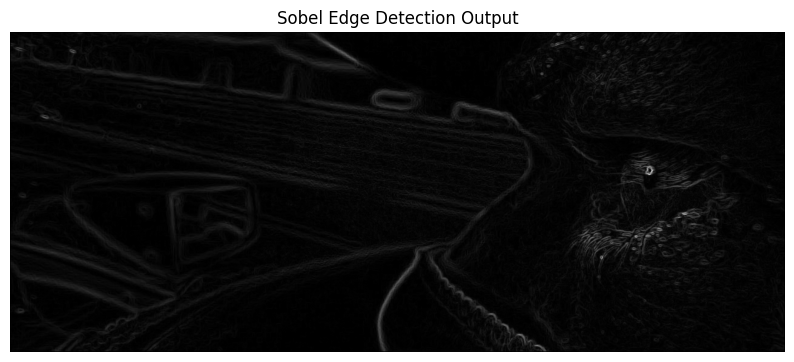

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

img = plt.imread("output.pgm")
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Sobel Edge Detection Output")

In [ ]:
pip install pillow
